In [2]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = fdr.DataReader('086520', '2021-01-01', '2023-07-01')

df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-06-26,759000,777000,758000,761000,368769,0.003958
2023-06-27,756000,760000,712000,738000,812930,-0.030223
2023-06-28,747000,752000,699000,700000,648809,-0.051491
2023-06-29,705000,735000,696000,714000,625782,0.020000
2023-06-30,726000,760000,715000,754000,668650,0.056022


In [4]:
df.shape

(617, 6)

In [5]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

In [6]:
dfx = df[['Open', 'High', 'Low', 'Close', 'Volume']]
dfx = MinMaxScaler(dfx)

dfy = dfx[['Close']]
dfx = dfx[['Open', 'High', 'Low', 'Volume']]

dfx

,Open,High,Low,Volume
Date,,,,
2021-01-04,0.043032,0.042956,0.042551,0.252685
2021-01-05,0.044914,0.043116,0.044641,0.166713
2021-01-06,0.045344,0.042794,0.044641,0.133096
2021-01-07,0.046198,0.045207,0.046033,0.215839
2021-01-08,0.048767,0.047862,0.048905,0.218127
...,...,...,...,...
2023-06-26,0.984436,0.947561,1.000000,0.053683
2023-06-27,0.980545,0.926829,0.939314,0.118341
2023-06-28,0.968872,0.917073,0.922164,0.094449


In [7]:
dfx.describe()

,Open,High,Low,Volume
count,617.000000,617.000000,617.000000,617.000000
mean,0.196938,0.192419,0.194062,0.126813
std,0.227732,0.224077,0.222582,0.121733
min,0.000000,0.000000,0.000000,0.000000
25%,0.087432,0.085761,0.085599,0.053641
50%,0.122307,0.118251,0.121391,0.089322
75%,0.163813,0.158445,0.163061,0.162161
max,1.000000,1.000000,1.000000,1.000000


In [8]:
dfy.head()

,Close
Date,
2021-01-04,0.000715
2021-01-05,0.000179
2021-01-06,0.000000
2021-01-07,0.002593
2021-01-08,0.005279


In [9]:
time_step = 10
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v)
        ys.append(labels)

    return np.array(Xs), np.array(ys)

In [10]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(607, 10, 4)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((485, 10, 4), (122, 10, 4), (485, 1), (122, 1))

In [12]:
n_timesteps,n_features,n_outputs=X_train.shape[1],X_train.shape[2],y_train.shape[1]

In [13]:
n_timesteps, n_features, n_outputs

(10, 4, 1)

In [14]:
dfx.shape

(617, 4)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Conv1D, MaxPooling1D, Flatten

In [22]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 8, 64)             832       
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 64)             12352     
                                                                 
 dropout_2 (Dropout)         (None, 6, 64)             0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                12352     
                                                      

In [23]:
model.compile(loss='mse', optimizer='adam')

In [24]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 0.1886
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.1082
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 6.6855e-04 - val_loss: 0.0879
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 3.4953e-04 - val_loss: 0.0774
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 5.0542e-04 - val_loss: 0.0643
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 3.8792e-04 - val_loss: 0.0821
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 2.9710e-04 - val_loss: 0.0810
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 2.8827e-04 - val_loss: 0.0826
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 2.5029e-04 - val_loss: 0.0820
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 2.6902

Epoch 80/100
16/16 [==============================] - 0s 5ms/step - loss: 1.5143e-04 - val_loss: 0.0736
Epoch 81/100
16/16 [==============================] - 0s 5ms/step - loss: 1.2083e-04 - val_loss: 0.0697
Epoch 82/100
16/16 [==============================] - 0s 5ms/step - loss: 1.2113e-04 - val_loss: 0.0673
Epoch 83/100
16/16 [==============================] - 0s 5ms/step - loss: 1.2184e-04 - val_loss: 0.0683
Epoch 84/100
16/16 [==============================] - 0s 5ms/step - loss: 9.6963e-05 - val_loss: 0.0652
Epoch 85/100
16/16 [==============================] - 0s 4ms/step - loss: 1.0300e-04 - val_loss: 0.0694
Epoch 86/100
16/16 [==============================] - 0s 5ms/step - loss: 8.7461e-05 - val_loss: 0.0687
Epoch 87/100
16/16 [==============================] - 0s 5ms/step - loss: 7.9651e-05 - val_loss: 0.0694
Epoch 88/100
16/16 [==============================] - 0s 4ms/step - loss: 8.6118e-05 - val_loss: 0.0720
Epoch 89/100
16/16 [==============================] - 0s 4ms/ste

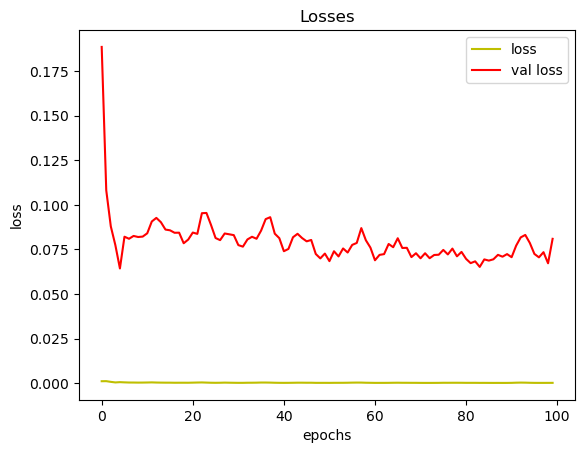

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [53]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


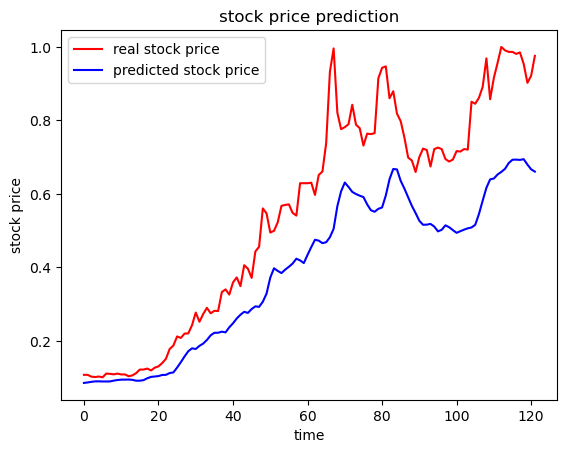

In [54]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()